# Angular correlation functions

Instead of measuring two-point statistics in harmonic space (i.e., angular power spectra), many surveys choose to measure angular correlation functions in real space. The advantage is that angular correlations can be measured directly from the data, with no integral transform, and hence no imprint of the survey geometry. The disadvantage, as you will find below, is that it takes much longer to compute angular correlation functions.

For cosmic shear, with its two shear components, the two correlations are typically called $\xi^+$ and $\xi^-$:
$$
    \xi^\pm
    = \frac{
        \sum_{ij} w_i w_j \, (\epsilon_{t,i} \, \epsilon_{t,j} \pm \epsilon_{\times,i} \, \epsilon_{\times,j})
    }{
        \sum_{ij} w_i w_j
    }
$$
These correlations are weighted averages of the sum and difference of two-point estimates of the tangential ellipticities $\epsilon_t$ and cross-ellipticities $\epsilon_\times$ over some set of pairs $(i, j)$ of objects. (If there are many objects, there are many-squared pairs of objects, which is the reason why it is generally slow to compute angular correlations, and requires some clever computational tricks to become practically feasible.)

We then need to define exactly for which pairs of objects we want to compute the correlations. Cosmological information is extracted from the angular correlations $\xi^+(\theta)$ and $\xi^-(\theta)$ as a function of separation $\theta$ between the objects. We therefore average over objects $i$ and $j$ that are separated by a given angle $\theta$ or, in practice, with separation falling into a narrow angular bin $[\theta, \theta + \Delta\theta)$. Furthermore, to do a tomographic analysis, the pairs of objects are selected across all tomographic redshift bin combinations.

To compute all of this, there is a convenient software package called [TreeCorr](https://rmjarvis.github.io/TreeCorr/), which we we are going to use below.

## Set up

Some standard imports ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

... and some imports for this particular analysis.

In [2]:
import fitsio
import treecorr

## Tomographic bins

Here, we can recycle the tomographic bins from our previous analysis.

In [3]:
# number of tomographic bins
nbin = 6

# tomographic redshift bin edges, copied from previous results
zbins = [
    0.0,
    5.99987664e-01,
    8.31252702e-01,
    1.04654674e+00,
    1.28845510e+00,
    1.62225091e+00,
    3.43605664e+00,
]

## Catalogs

For TreeCorr, we construct individual catalogues for the tomographic bins by reading the full FITS file and selecting the rows for each tomographic bin.

In [4]:
# read the entire catalogue
cat = fitsio.read("catalog.fits")

# set up the TreeCorr catalogs for tomographic bins
catalogs = {}
for i, z1, z2 in zip(range(1, nbin + 1), zbins, zbins[1:]):
    selection = (z1 <= cat["PHZ"]) & (cat["PHZ"] < z2)
    catalogs[i] = treecorr.Catalog(
        ra=cat["RA"][selection],
        ra_units="deg",
        dec=cat["DEC"][selection],
        dec_units="deg",
        g1=cat["E1"][selection],
        g2=cat["E2"][selection],
        w=cat["WEIGHT"][selection],
        flip_g2=True,
    )

## Correlation functions

TreeCorr takes a configuration dictionary that tells it how to compute the correlation functions. We need to set up the angular binning; here we use 20 logarithmic bins (the default) between 0.5 and 5.0 degrees. We also want to see some status output while the computation is ongoing.

In [5]:
# configuration dict, see https://rmjarvis.github.io/TreeCorr/_build/html/correlation2.html#treecorr.Corr2
config = {
    "nbins": 20,
    "min_sep": 0.5,
    "max_sep": 5.0,
    "sep_units": "deg",
    "verbose": 2,
    "output_dots": False,
}

We are ready to compute the cosmic shear ("GG") correlations for each bin combination. We store them in a dictionary similar to what Heracles uses, with entries `"xip"` and `"xim"` for $\xi^+$ and $\xi^-$, respectively.

In [6]:
corr = {}
for i in range(1, nbin + 1):
    for j in range(i, nbin + 1):
        print(f"processing bins {i} x {j}")
        gg = treecorr.GGCorrelation(config)
        gg.process(catalogs[i], catalogs[j])
        corr["xip", i, j] = gg.xip
        corr["xim", i, j] = gg.xim
        print("---")

processing bins 1 x 1
nbins = 20, min,max sep = 0.5..5 deg, bin_size = 0.115129
Starting process GG cross-correlations
Using 8 threads.
Starting 1024 jobs.
varG1 = 0.041607: sig_sn (per component) = 0.203978
varG2 = 0.041607: sig_sn (per component) = 0.203978
---
processing bins 1 x 2
nbins = 20, min,max sep = 0.5..5 deg, bin_size = 0.115129
Starting process GG cross-correlations
Using 8 threads.
Starting 1024 jobs.
varG1 = 0.041607: sig_sn (per component) = 0.203978
varG2 = 0.041613: sig_sn (per component) = 0.203994
---
processing bins 1 x 3
nbins = 20, min,max sep = 0.5..5 deg, bin_size = 0.115129
Starting process GG cross-correlations
Using 8 threads.
Starting 1024 jobs.
varG1 = 0.041607: sig_sn (per component) = 0.203978
varG2 = 0.041618: sig_sn (per component) = 0.204005
---
processing bins 1 x 4
nbins = 20, min,max sep = 0.5..5 deg, bin_size = 0.115129
Starting process GG cross-correlations
Using 8 threads.
Starting 1024 jobs.
varG1 = 0.041607: sig_sn (per component) = 0.203978


To show the results, we need to assign a set of nominal angles to our logarithmic angular binning. We can just copy it from TreeCorr.

In [7]:
# nominal angular bin centres, same for all bins so just copy last one
theta = np.copy(gg.rnom)

## Theory

We can use CAMB to compute a rough theoretical prediction for our measured angular correlation functions. (It is rough, because there are a number of subtleties when going from spectra, which is what all theory codes compute in the first place, to correlation functions.)

First, we need to load the redshift distributions we previously saved.

In [8]:
with np.load("nz.npz") as npz:
    z, nz = npz["z"], npz["nz"]

Then, we compute the theoretical spectra using CAMB, exactly as before.

In [9]:
import camb
import camb.correlations
from camb.sources import SplinedSourceWindow

# cosmology for the analysis
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)
pars.min_l = 1
pars.Want_CMB = False
pars.set_for_lmax(2000, lens_potential_accuracy=1);

# centres of the redshift bins
zmid = (z[:-1] + z[1:]) / 2

# create distributions for CAMB
sources = []
for i in range(nbin):
    source = SplinedSourceWindow(source_type="lensing", z=zmid, W=nz[i])
    sources.append(source)
pars.SourceWindows = sources

# compute spectra
camb_cls = camb.get_results(pars).get_source_cls_dict(lmax=2000)

# factor for kappa -> gamma conversion
ell = np.arange(2001)
fl = -np.sqrt((ell + 2) * (ell + 1) * ell * (ell - 1))
fl /= np.clip(ell * (ell + 1), 1, None)

We can now use CAMB's functionality to turn the expected spectra into expected correlation functions. This is a bit of a hack: for each tomographic bin combination, we turn the computed spectrum into an $EE$ spectrum, and set the rest of the CMB spectra $TT$, $BB$, and $TE$ to zero. We can pass this to CAMB, which returns correlation functions for $T$, $Q+U$ (which is our $\xi^+$), $Q-U$ (which is our $\xi^-$), and cross, from which we store what we need.

In [10]:
# compute expected correlation functions
theory = {}
for i in range(1, nbin + 1):
    for j in range(i, nbin + 1):
        # get lensing spectrum from CAMB
        cl = camb_cls[f"W{i}xW{j}"]

        # convert into array that CAMB wants for correlations
        # i.e., CMB spectra for TT, EE, BB, TE
        cls = np.transpose([
            np.zeros_like(cl),
            cl * fl**2,
            np.zeros_like(cl),
            np.zeros_like(cl),
        ])

        # use CAMB to compute correlations at our values of theta
        camb_corr = camb.correlations.cl2corr(cls, np.cos(np.radians(theta)))

        # store results
        theory["xip", i, j] = camb_corr[:, 1]  # Q+U == xi^+
        theory["xim", i, j] = camb_corr[:, 2]  # Q-U == xi^-

Time to show the results!

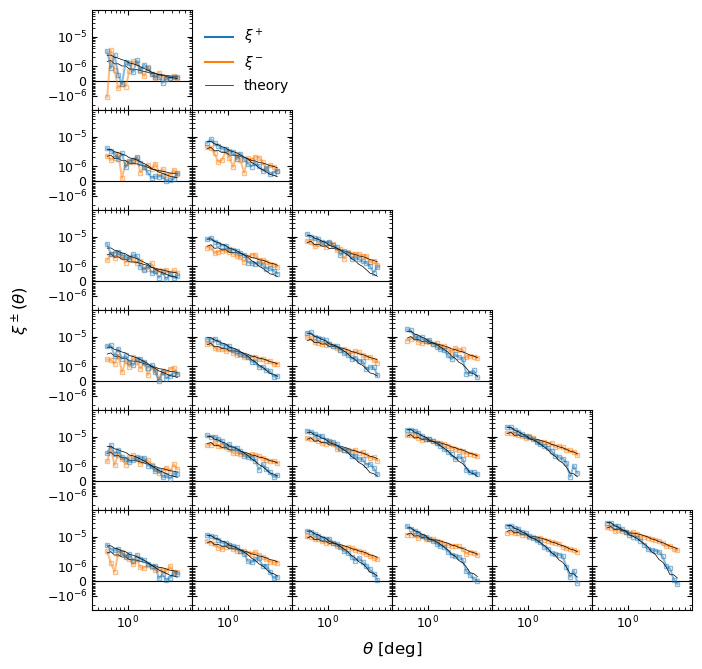

In [11]:
def plot_corr(corr):
    """
    Plot a set of angular correlation functions.
    """

    fig, ax = plt.subplots(nbin, nbin, figsize=(nbin, nbin), sharex=True, sharey=True)
    fig.tight_layout(pad=0.0)
    
    for i in range(1, nbin + 1):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbin + 1):
            ax[j - 1, i - 1].plot(theta, corr["xip", i, j], "s-", c="C0", ms=3.0, mfc="none", lw=1.5, zorder=3.0, alpha=0.5)
            ax[j - 1, i - 1].plot(theta, corr["xim", i, j], "s-", c="C1", ms=3.0, mfc="none", lw=1.5, zorder=1.0, alpha=0.5)
            ax[j - 1, i - 1].plot(theta, theory["xip", i, j], c="k", lw=0.5, zorder=3.0)
            ax[j - 1, i - 1].plot(theta, theory["xim", i, j], c="k", lw=0.5, zorder=1.0)
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in", labelsize=9.0,
                                         top=True, bottom=True, left=True, right=True)
    
    ax[0, 1].legend(
        handles=[
            plt.Line2D([0], [0], c="C0", lw=1.5, label="$\\xi^+$"),
            plt.Line2D([0], [0], c="C1", lw=1.5, label="$\\xi^-$"),
            plt.Line2D([0], [0], c="k", lw=0.5, label="theory"),
        ],
        loc="center left",
        frameon=False,
    )
    
    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(0.5 / 1.5, 5.0 * 1.5)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(numticks=99, subs=np.arange(0.1, 1.0, 0.1))
    ax[0, 0].set_yscale("symlog", linthresh=1e-6, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
    ax[0, 0].set_ylim(-3e-6, 8e-5)
    
    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
    
    fig.supxlabel("$\\theta$ [deg]", y=-0.3 / nbin, va="top")
    fig.supylabel("$\\xi^\\pm(\\theta)$", x=-0.6 / nbin, ha="right")

    return fig, ax


plot_corr(corr)
plt.show()

You may notice slight wiggles in the theoretical expectation. This is exactly caused by the difficulties in converting from expected spectra to expected correlation functions.